In [781]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torchbnn as bnn 
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.metrics import (accuracy_score, precision_score, confusion_matrix,
                             roc_auc_score, brier_score_loss, roc_curve,
                             mean_squared_error, mean_absolute_error, r2_score,  classification_report,
                             )


from sklearn.calibration import calibration_curve
from xgboost import XGBClassifier 
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import time

**Traditional neural networks** learn fixed numbers to make predictions, even if the training data is small or messy.<br>
**BNNs** use ranges of possible values (probability distributions) for weights, BNNs sample multiple guesses from those ranges. <br>If the guesses are similar, the model is confident; if they vary wildly, it admits uncertainty.

**Important concepts:**<br>
<p>Prior: How wide the weight distributions should be before data</p><br>
<p>

In [743]:
# I am using the diabetes dataset from Introduction ML Course 
df = pd.read_csv('diabetes_cleaned.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.00,79.8,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.00,79.8,26.6,0.351,31.0,0
2,8.0,183.0,64.0,20.54,79.8,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.00,94.0,28.1,0.167,21.0,0
4,0.0,137.0,40.0,35.00,168.0,43.1,1.200,33.0,1


**Preprocessing**

In [744]:
df.shape

(768, 9)

In [745]:
# Features and target value
# Since I will train BBN model in Pytorch framework, I need numpy array with no label
X = df.drop(columns=['Outcome']).values 
y = df['Outcome'].values 

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Making train/ validation and test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


# Convert NumPy arrays into PyTorch tensors
X_train, X_val, X_test = [torch.tensor(a, dtype=torch.float32) for a in (X_train, X_val, X_test)]
y_train, y_val, y_test = [torch.tensor(a, dtype=torch.long)   for a in (y_train, y_val, y_test)]

print(f'X train shape:{X_train.shape} y train shape:{y_train.shape}')
print(f'\nX validation shape:{X_val.shape} validation shape:{y_val.shape}')
print(f'\nX test shape:{X_test.shape} y test shape:{y_test.shape}')

X train shape:torch.Size([614, 8]) y train shape:torch.Size([614])

X validation shape:torch.Size([77, 8]) validation shape:torch.Size([77])

X test shape:torch.Size([77, 8]) y test shape:torch.Size([77])


In [746]:
# Bundle tensors into mini-batch loaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64, shuffle=False)
print(f'Train loader: {len(train_loader)} batches')
print(f'Validation loader: {len(val_loader)} batches')
print(f'Test loader: {len(test_loader)} batches')

Train loader: 10 batches
Validation loader: 2 batches
Test loader: 2 batches


**Building the Bayesian Neural Network Model**

In [747]:
# I define the Bayesian neural network architecture 

class ClassificationBNN(nn.Module):
    def __init__(self, input_dim, output_dim, mu = 0, sigma = 0.7):
        super(ClassificationBNN, self).__init__()
        self.fc1 = bnn.BayesLinear(prior_mu=mu, prior_sigma = sigma, in_features=input_dim, out_features=128)
        self.fc2 = bnn.BayesLinear(prior_mu=mu, prior_sigma = sigma, in_features=128, out_features=64)
        self.fc3 = bnn.BayesLinear(prior_mu=mu, prior_sigma = sigma, in_features =64, out_features = 32)
        self.fc4 = bnn.BayesLinear(prior_mu=mu, prior_sigma = sigma, in_features =32, out_features = 16)
        self.out = bnn.BayesLinear(prior_mu=mu, prior_sigma = sigma, in_features =16, out_features = output_dim)
        self.relu = nn.ReLU()            
        
        
        self.bn1, self.bn2, self.bn3, self.bn4 = nn.BatchNorm1d(128), nn.BatchNorm1d(64), nn.BatchNorm1d(32), nn.BatchNorm1d(16)  
        self.dropout = nn.Dropout(0.2)  
        
        
    def forward(self, x, mc_dropout=False):
        x = self.dropout(self.bn1(self.relu(self.fc1(x)))) if mc_dropout else self.bn1(self.relu(self.fc1(x)))
        x = self.dropout(self.bn2(self.relu(self.fc2(x)))) if mc_dropout else self.bn2(self.relu(self.fc2(x)))
        x = self.dropout(self.bn3(self.relu(self.fc3(x)))) if mc_dropout else self.bn3(self.relu(self.fc3(x)))
        x = self.dropout(self.bn4(self.relu(self.fc4(x)))) if mc_dropout else self.bn4(self.relu(self.fc4(x)))
        return self.out(x)
    
    
# I have 8 features and 1 output 
# I defined 3 hidden layers with 128, 64, 32 neurons and 16 to extract the features from the input data
# The Final layer has 1 output neuron since my dataset is binary classification
# I defined dropout and batch normalization layers for regularization

# In this structure:
# bnn.BayesLinear layers replace nn.Linear that maintain distributions over weights and biases instead of single values
# The forward method defines how input data flows through the network.

# I initialized prior_ mu to 0 because what I have learned, it is a common  practice to keep weights neutral 
# at the beginning of training.
# I initialized prior_sigma to 0.5 that weights to as adapt more freely during training.

**Initializing model anf Hyperparameter**

In [748]:
# Hyperparameters:
lambda_kl = 0.1 
mc_samples_eval = 50
learning_rate = 0.0009
weight_decay = 0.0005

# I initialize lambda_kl to 0.01, which is not too high to force the wights to be close to the prior distribution
# 50 samples for Monte Carlo  is a good number to learn distribution of weights after training.
# 100 samples is a good number to estimate the uncertainty 
# learning rate is 0.0009 is safe for adam optimizer to learn stable without overshooting
# weight decay is 0.0005 to prevent overfitting and improve generalization of the model
criterion = nn.BCEWithLogitsLoss()
kl_loss = bnn.BKLLoss(reduction = 'mean')
# I use BKLLoss to calculate the Kullback-Leibler divergence between the learned distribution and the prior distribution 
model  = ClassificationBNN(input_dim=8, output_dim=1, mu=0, sigma=0.5)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  

**Training Loop**

In [749]:
@torch.no_grad()                                     
def evaluate(model, loader, mc_samples=mc_samples_eval, threshold=0.5):
    model.eval()                                  
    all_probs, all_true = [], []

    for input_feature, true_label in loader:  
        # Monte Carlo sampling for uncertainty estimation  
        # By running the model multiple times with dropout, I can capture the uncertainty in the predictions  
        # Adding  new dimension to aggregate Monte Carlo samples 
        # Each time returns tensor of shape (batch_size, 1) logits for binary classification         
        mc_logits = torch.stack([model(input_feature, mc_dropout=True) for _ in range(mc_samples)])  
        # Applying sigmoid to convert logits to probabilities
        # Taking average over the Monte Carlo samples 
        probs = torch.sigmoid(mc_logits).mean(0).squeeze(1)
        # Collecting probabilities and true labels for evaluation
        all_probs.append(probs)
        all_true.append(true_label)
    # Compute metrics
    probs = torch.cat(all_probs)                      
    y_true = torch.cat(all_true).float()
    # Convert probabilities to class labels using the threshold
    y_pred = (probs >= threshold).float()             
    # Calculate accuracy by comparing predicted labels with true labels  
    accuracy = (y_pred == y_true).float().mean().item()      
    return accuracy, probs, y_true                    


In [750]:
# Training the model 
def train(model, loader, optimizer, Lambda_kl=lambda_kl):
    # training mode
    model.train()
    running = 0

    for input_feature, true_label in loader:
        # Zero Gradients 
        optimizer.zero_grad()
        # Forward pass: compute  raw output from input features
        logits = model(input_feature, mc_dropout=True)   
        # Compute the loss        
        loss_data = criterion(logits.squeeze(1), true_label.float())
        # Compute the KL divergence loss:
        # Iterates over all layers amd filters layers that have a kl_loss() method 
        # And st the end, computes the KL divergence for each Bayesian layer between its posterior and prior distributions.
        kl = sum(m.kl_loss() for m in model.modules()if hasattr(m, 'kl_loss'))
        loss = loss_data + Lambda_kl * kl
        loss.backward()
        optimizer.step()
        running += loss.item() * input_feature.size(0)
    return running / len(loader.dataset)
# I did not use float32 for the labels  and I got an error:
# RuntimeError: result type Float can't be cast to the desired output type Long
# I used Qwen to ask why I got this error and it suggested to float the labels for compatibility with
# the BCEWithLogitsLoss 

In [ ]:
# History and hyperparameters
history = {'train_loss': [], 'val_acc': [], 'val_nll': []}
best_val_nll = float('inf')
PATIENCE = 20
# I created empty list to hold  the validation negative log likelihood (val_nll) and accuracy for each epoch
# Validation negative log likelihood is used to evaluate how well a probabilistic model  predicts the true labels on a validation dataset.

In [752]:
# Training loop 
print('Training the model...')
start_time = time.time()

for epoch in tqdm(range(500), desc='Epoch Progress'):
    # Compute validation negative log likelihood using the BCEWithLogitsLoss 
    # to measure predictive uncertainty
    train_loss = train(model, train_loader, optimizer, lambda_kl)
    val_acc, val_probs, val_true = evaluate(model, val_loader, mc_samples=50)
    val_nll = criterion(val_probs, val_true).item() 
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
    scheduler.step(val_nll) 
    
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_nll'].append(val_nll)
    
    
    # If val_nll is lower than the best_val_nll, update the best_val_nll and reset patience_counter
    # Otherwise,  +1 is added to patience_counter, This is used to for early stopping
    if val_nll < best_val_nll:
        best_val_nll = val_nll
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= PATIENCE:
        print(f'\nEarly stopping at Epoch {epoch} | Best Val NLL: {best_val_nll:.3f}')
        break
print(f'Training finished! Total duration: {time.time() - start_time:.2f}s')

Training the model...


Epoch Progress:  20%|██        | 100/500 [00:12<00:50,  7.93it/s]


Early stopping at Epoch 100 | Best Val NLL: 0.744
Training finished! Total duration: 12.62s


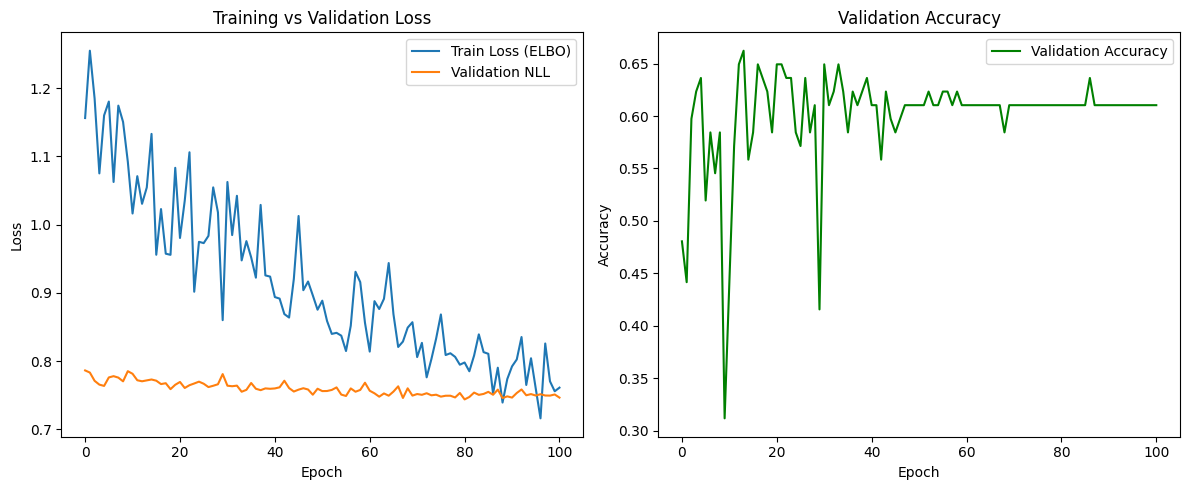

In [753]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss (ELBO)')
plt.plot(history['val_nll'], label='Validation NLL')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['val_acc'], label='Validation Accuracy', color='green')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

**XGBoost Baseline (Classification)**

In [764]:
# I will  train  XGBoost classifier on the same data
x= df.drop(columns=['Outcome']) 
y= df['Outcome']


In [772]:
# Split data into training and testing
X_Train, X_Test, y_Train, y_Test = train_test_split(x, y, test_size=0.2, random_state=42)

In [773]:
# XGBoost classifier
xgb_model = XGBClassifier(random_state=42)


# I will use RandomizedSearchCV to find the best hyperparameters for the XGBoost model
param_dist = {
   'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Hyperparameter tuning with RandomizedSearchCV
xgb_random = RandomizedSearchCV(estimator = xgb_model, param_distributions=param_dist, n_iter=10, cv=3, verbose=1, random_state=42)


# Train model
xgb_random.fit(X_Train, y_Train)

# Getting best model from search
best_xgb_model = xgb_random.best_estimator_ 

# Predictions and probabilities
y_pred_xgb = best_xgb_model.predict(X_Test)
y_pred_proba_xgb = best_xgb_model.predict_proba(X_Test)[:, 1]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [ ]:
print("Best Parameters:", xgb_random.best_params_)  # Show optimal hyperparameters [[7]]
print("\nClassification Report:")
print(classification_report(y_Test, y_pred_xgb)) 

Best Parameters: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        99
           1       0.64      0.64      0.64        55

    accuracy                           0.74       154
   macro avg       0.72      0.72      0.72       154
weighted avg       0.74      0.74      0.74       154



In [780]:
print(f"Accuracy: {accuracy_score(y_Test, y_pred_xgb):.2f}")
print(f"Precision: {precision_score(y_Test, y_pred_xgb):.2f}")
print(f"F1 Score: {f1_score(y_Test, y_pred_xgb):.2f}")
print(f"ROC AUC Score: {roc_auc_score(y_Test, y_pred_proba_xgb):.2f}")

Accuracy: 0.74
Precision: 0.64
F1 Score: 0.64
ROC AUC Score: 0.82
